In [5]:
import os
import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
import utils
from utils import ext_transforms as et
from utils.nerve import Nerve

import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
from utils import ext_transforms as et
from utils.nerve import Nerve
from utils.utils import Params

args = {
    "param_ckpt" : "/home/dongik/src/cpn-TMP640-result/Oct18-20-01-42_demo/best-param/run_00/fold_02",
    "dst_pth" : "/home/dongik/src/cpn-TMP640-result/Oct18-20-01-42_demo",
    "data_pth" : "/home/dongik/datasets",
    "num_workers" : 8,
    "modality" : "UN",
    "region" : "peroneal",
    "kfold" : 5,
    "k" : 2,
    "batch_size" : 16,
}
opts = Params(json_path=os.path.join(args['dst_pth'], 'param-summary.json'))

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)
denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def cmap(N=4, preds=False):

        color_map = np.zeros((N, 3), dtype='uint8')
        color_map[0] = np.array([255, 255, 255])
        color_map[1] = np.array([204, 0, 0]) if preds else np.array([0, 0, 204])
        color_map[2] = np.array([255, 102, 102]) if preds else np.array([102, 102, 255])
        color_map[3] = np.array([0, 51, 0]) if preds else np.array([0, 255, 0])

        return color_map

def get_pnt(pnt, crop_size):
    # Height
    if pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (int(pnt[0] - crop_size[0]/2), 0)
        rb = (int(pnt[0] + crop_size[0]/2), 0)
    elif pnt[0] < crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (0, 0)
        rb = (crop_size[0], 0)
    elif pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) < crop_size[0]/2:
        lt = (640 - crop_size[0], 0)
        rb = (640, 0)
    lt = list(lt)
    rb = list(rb)
    # Width
    if pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = int(pnt[1] - crop_size[1]/2)
        rb[1] = int(pnt[1] + crop_size[1]/2)
    elif pnt[1] < crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = 0
        rb[1] = crop_size[1]
    elif pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) < crop_size[1]/2:
        lt[1] = 640 - crop_size[1]
        rb[1] = 640

    return lt, rb

def show(ims, mas, bbox, outputs, pmas, crop_size=256, save=False, verbose=False):
    """ 
    Args:
        ims (Tensor)
    """
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    pcmap = cmap(preds=True)
    tcmap = cmap(preds=False)

    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

        mtar = torch.zeros(mas[0].shape, 
                    device='cpu', dtype=torch.long, )

        true_anchor = ((bbox[i].numpy() * 640) + 320).astype(np.int32)
        pred_anchor = ((outputs[i].numpy() * 640) + 320).astype(np.int32)

        print(ims[i].size(), mtar.size())
        print(true_anchor, pred_anchor)

        mtar[pmas[i] > 0] = 1
        mtar[mas[i] > 0] += 2
        mtar = pcmap[mtar.numpy()]

        # pred
        lt, rb = get_pnt(pred_anchor, crop_size)
        pmas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        pmas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        pmas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        pmas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        pmas[i, pred_anchor[0]-3:pred_anchor[0]+3, pred_anchor[1]-30:pred_anchor[1]+30] = 2
        pmas[i, pred_anchor[0]-30:pred_anchor[0]+30, pred_anchor[1]-3:pred_anchor[1]+3] = 2
        ptar = pcmap[pmas[i].numpy()]

        # true
        lt, rb = get_pnt(true_anchor, crop_size)
        mas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        mas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        mas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        mas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        mas[i, true_anchor[0]-3:true_anchor[0]+3, true_anchor[1]-30:true_anchor[1]+30] = 2
        mas[i, true_anchor[0]-30:true_anchor[0]+30, true_anchor[1]-3:true_anchor[1]+3] = 2
        ttar = tcmap[mas[i].numpy()]

        
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(tar,)
        plt.subplot(1, 4, 2)
        plt.imshow(ttar, )
        plt.subplot(1, 4, 3)
        plt.imshow(ptar, )
        plt.subplot(1, 4, 4)
        plt.imshow(mtar, )
        plt.show()
        
        if save:
            ...
        if i == 5:
            break

def _show(ims, mas, ):
    cmp = cmap(preds=True)
    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)
        mtar = cmp[mas[i, ...].numpy()]
        plt.subplot(1, 2, 1)
        plt.imshow(tar, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(mtar, cmap='gray')
        plt.show()


def crop(ims, mas, anchor, devices, crop_size=256):
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    
    cims = torch.zeros((ims.shape[0], 3, crop_size[0], crop_size[1]), 
                        device=devices, dtype=ims.dtype, )
    cmas = torch.zeros((mas.shape[0], crop_size[0], crop_size[1]), 
                        device=devices, dtype=torch.long,)
    
    anchor = ((anchor * 640) + 320).type(torch.int32)
    
    for i in range(ims.size()[0]):

        lt, rb = get_pnt(anchor[i], crop_size)
        if i == 0:
            print(f"lt: {lt}, rb: {rb}")
        cims[i, ...] = ims[i, ...][... , lt[0]:rb[0], lt[1]:rb[1]]
        cmas[i, ...] = mas[i, ...][lt[0]:rb[0], lt[1]:rb[1]]
        
    return cims, cmas

def recover(mas, cmas, anchor, devices, crop_size=(256, 256)):
    anchor = ((anchor * 640) + 320).type(torch.int32)
    result = torch.zeros(mas.shape, 
                        device=devices, dtype=torch.long, )
    for i in range(mas.size()[0]):
        if i == 0:
            print(f"anchor[0]: {anchor[i]}")
        lt, rb = get_pnt(anchor[i], (256, 256))
        result[i, ...][lt[0]:rb[0], lt[1]:rb[1]] = cmas[i, ...]
    
    return result
    

In [3]:
devices = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = et.ExtCompose([
    et.ExtToTensor(),
    et.ExtNormalize(mean=norm[0], std=norm[1]),
    ])
    
dst = Nerve(root_pth=args['data_pth'], datatype=args['region'], modality=args['modality'], 
                        fold=f"v{args['kfold']}/{args['k']}", image_set='val', transform=transform, )

loader = DataLoader(dst, batch_size=args['batch_size'], 
                        num_workers=args['num_workers'], shuffle=True, drop_last=True)

print("Dataset - %s\n\tTest\t%d" % 
        (f"v{args['kfold']}/{args['k']}" + '/' + args['region'], len(dst) ))


Dataset - v5/2/peroneal
	Test	98


In [6]:
net = models.models.__dict__['deeplabv3plus_resnet50'](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'checkpoint.pt'), map_location='cpu')
net.load_state_dict(ckpt["model_state"])
net.to(devices)
net.eval()
print(f'Seg best epoch: { ckpt["cur_epoch"] }')

backbone = models.models.__dict__['backbone_vit'](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'backbone.pt'), map_location='cpu')
backbone.load_state_dict(ckpt["model_state"])
backbone.to(devices)
backbone.eval()
print(f'Backbone best epoch: { ckpt["cur_epoch"] }')

Seg best epoch: 1
Backbone best epoch: 1


  0%|          | 0/6 [00:00<?, ?it/s]

lt: [28, 208], rb: [284, 464]
crop images, masks size:  torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])
anchor[0]: tensor([156, 336], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[192 332] [156 336]


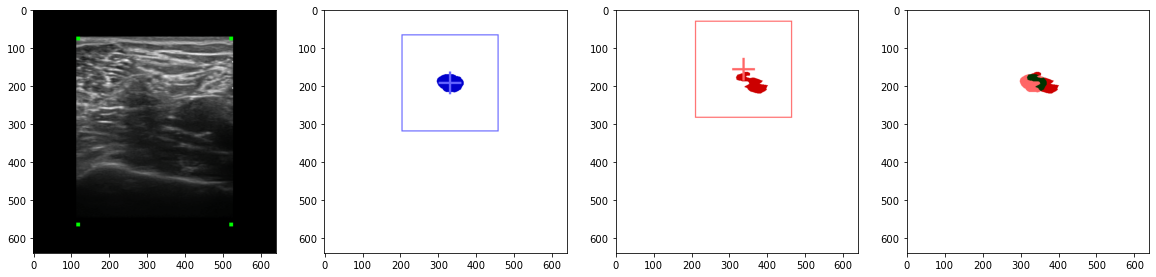

torch.Size([3, 640, 640]) torch.Size([640, 640])
[185 315] [156 337]


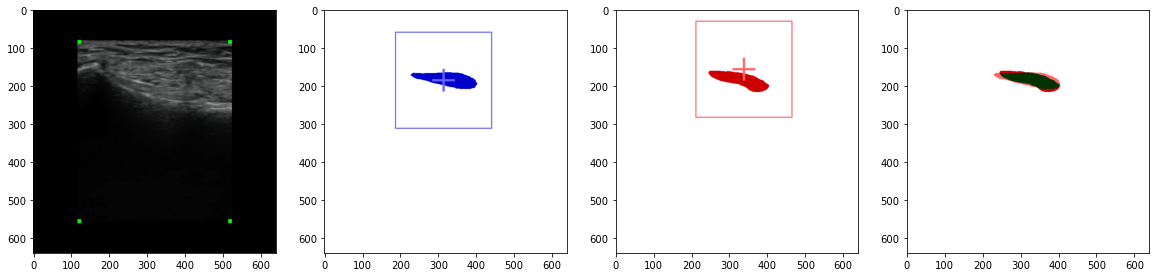

torch.Size([3, 640, 640]) torch.Size([640, 640])
[145 340] [156 337]


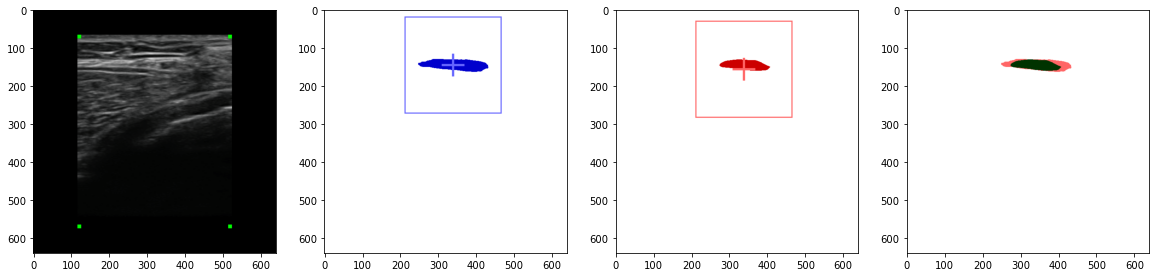

torch.Size([3, 640, 640]) torch.Size([640, 640])
[222 269] [167 338]


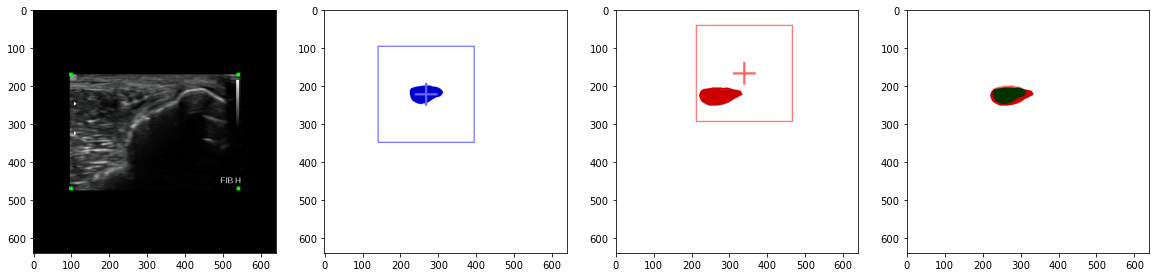

torch.Size([3, 640, 640]) torch.Size([640, 640])
[226 278] [156 336]


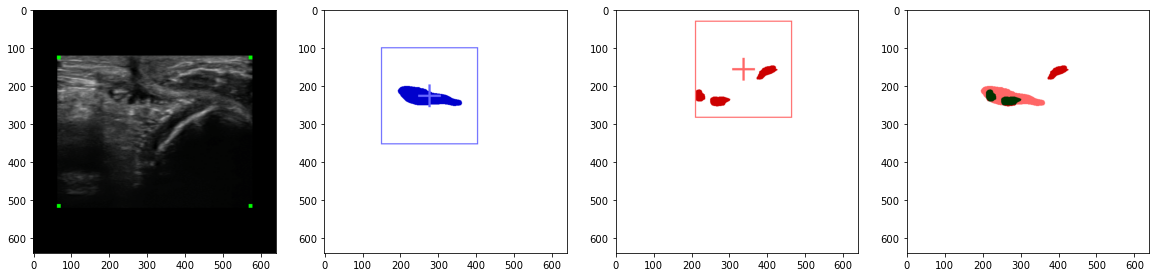

torch.Size([3, 640, 640]) torch.Size([640, 640])
[136 325] [154 331]


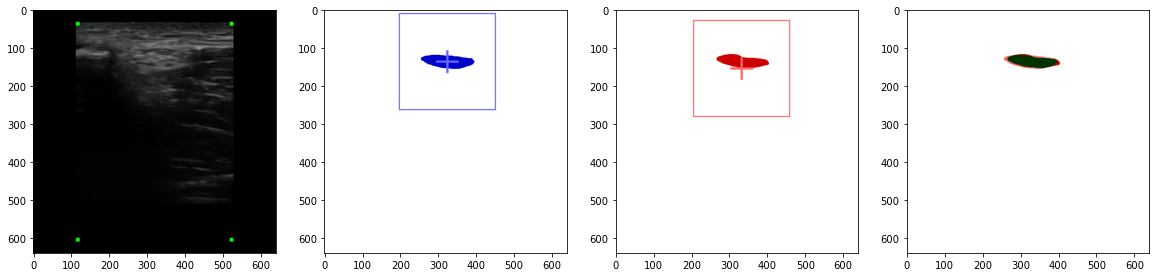

 17%|█▋        | 1/6 [00:04<00:21,  4.21s/it]

lt: [27, 207], rb: [283, 463]
anchor[0]: tensor([155, 335], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[208 295] [155 335]


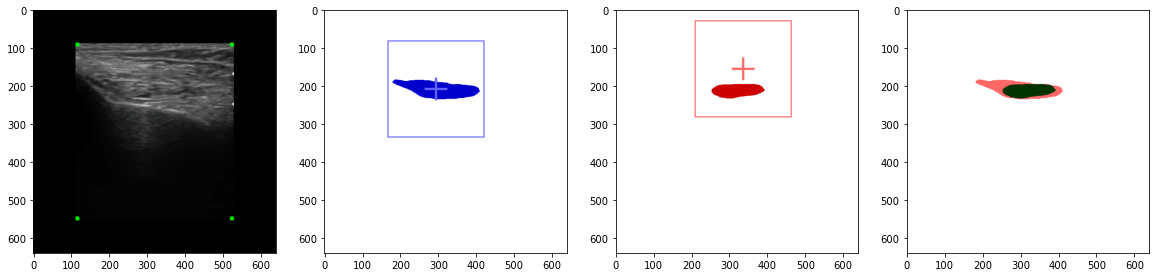

torch.Size([3, 640, 640]) torch.Size([640, 640])
[193 324] [156 336]


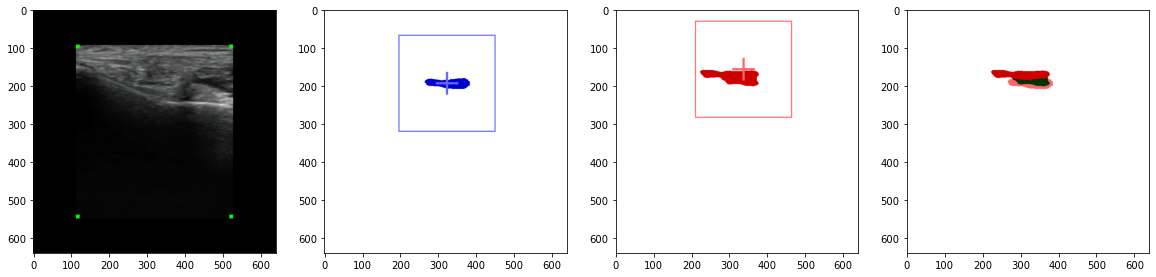

torch.Size([3, 640, 640]) torch.Size([640, 640])
[183 277] [156 336]


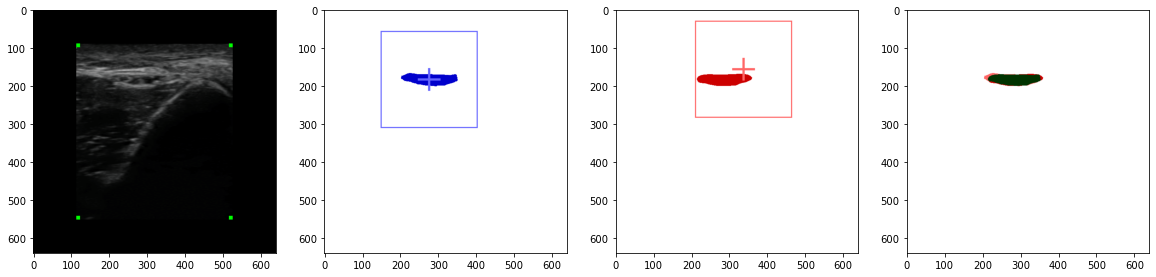

torch.Size([3, 640, 640]) torch.Size([640, 640])
[151 295] [157 336]


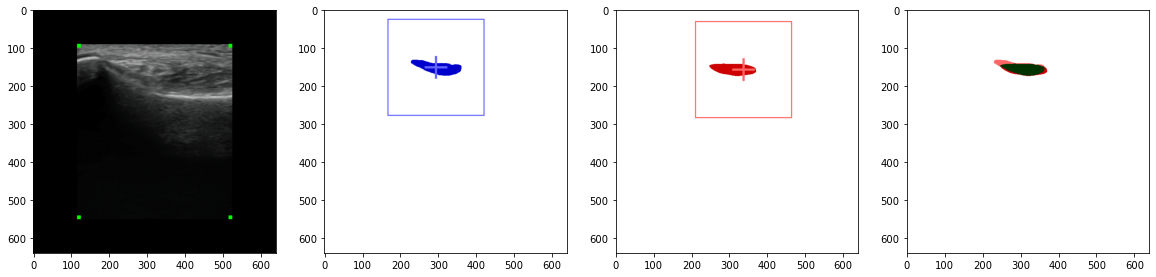

torch.Size([3, 640, 640]) torch.Size([640, 640])
[171 266] [156 336]


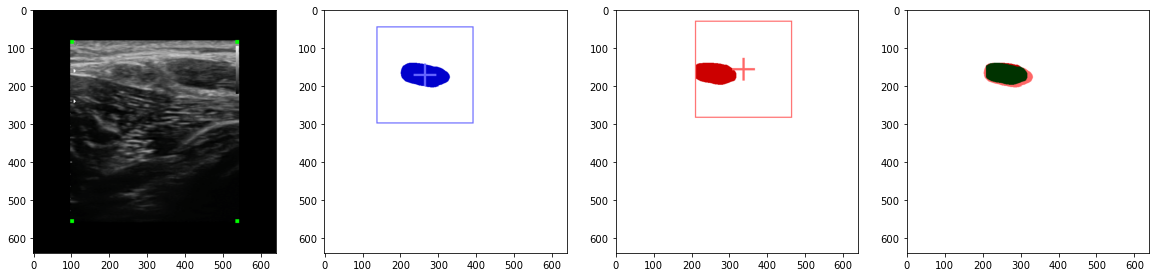

torch.Size([3, 640, 640]) torch.Size([640, 640])
[154 339] [156 336]


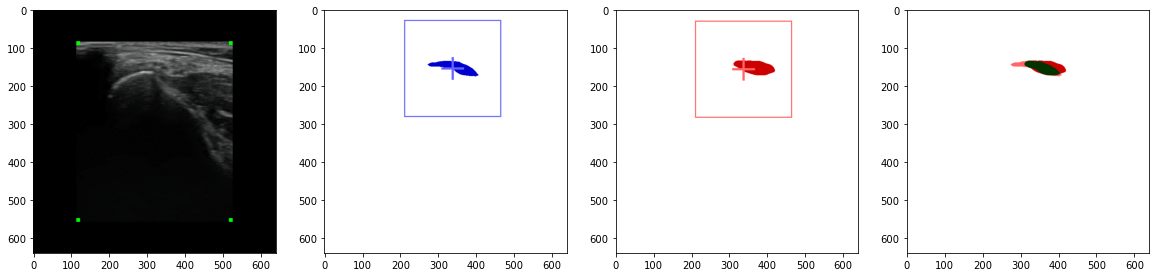

 33%|███▎      | 2/6 [00:08<00:16,  4.18s/it]

lt: [28, 208], rb: [284, 464]
anchor[0]: tensor([156, 336], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[198 371] [156 336]


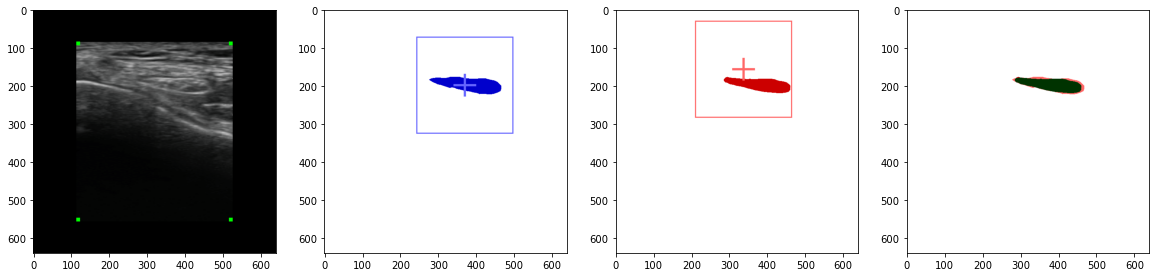

torch.Size([3, 640, 640]) torch.Size([640, 640])
[203 328] [156 336]


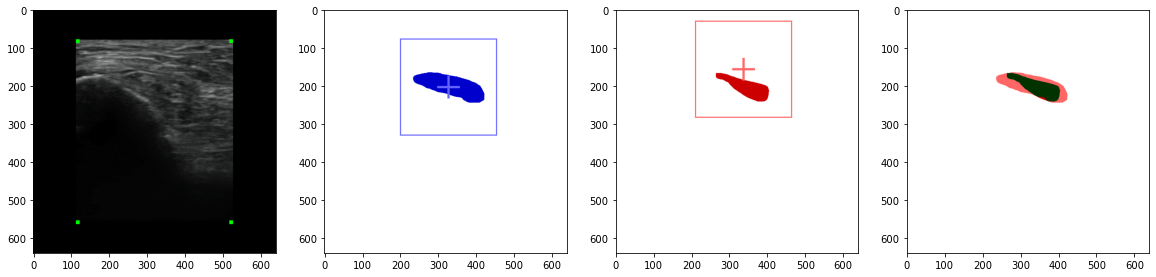

torch.Size([3, 640, 640]) torch.Size([640, 640])
[119 403] [156 337]


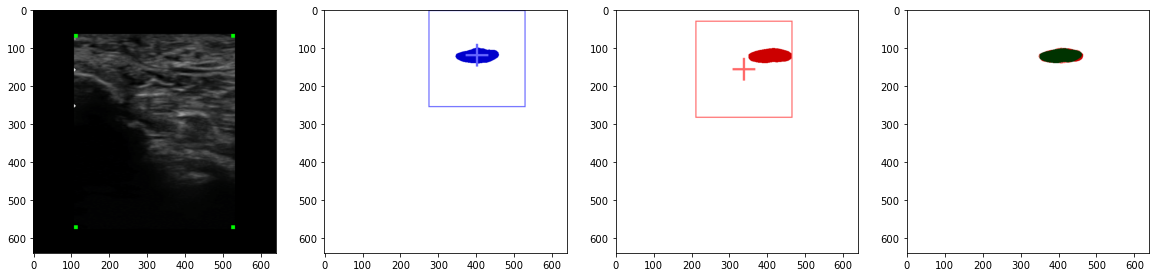

torch.Size([3, 640, 640]) torch.Size([640, 640])
[180 306] [156 336]


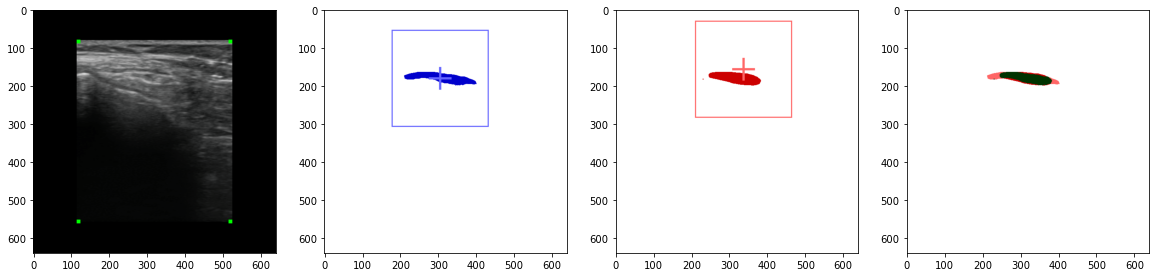

torch.Size([3, 640, 640]) torch.Size([640, 640])
[145 358] [156 336]


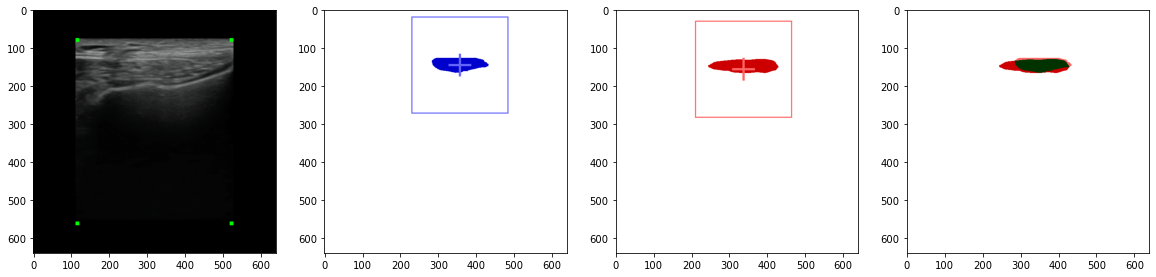

torch.Size([3, 640, 640]) torch.Size([640, 640])
[159 356] [156 336]


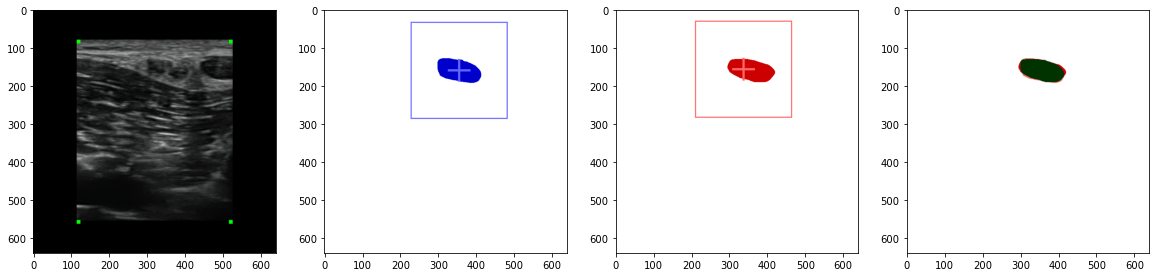

 50%|█████     | 3/6 [00:12<00:11,  3.97s/it]

lt: [27, 206], rb: [283, 462]
anchor[0]: tensor([155, 334], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[157 256] [155 334]


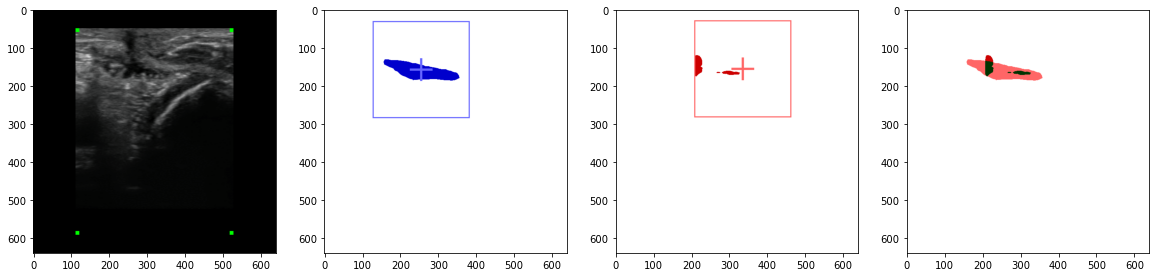

torch.Size([3, 640, 640]) torch.Size([640, 640])
[161 287] [156 336]


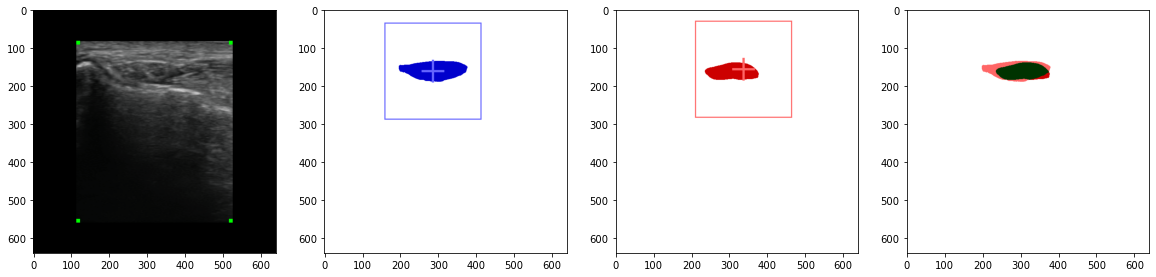

torch.Size([3, 640, 640]) torch.Size([640, 640])
[271 390] [156 337]


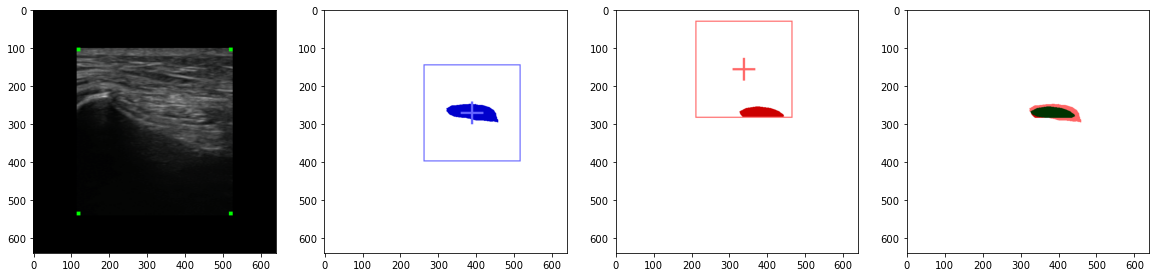

torch.Size([3, 640, 640]) torch.Size([640, 640])
[149 316] [155 336]


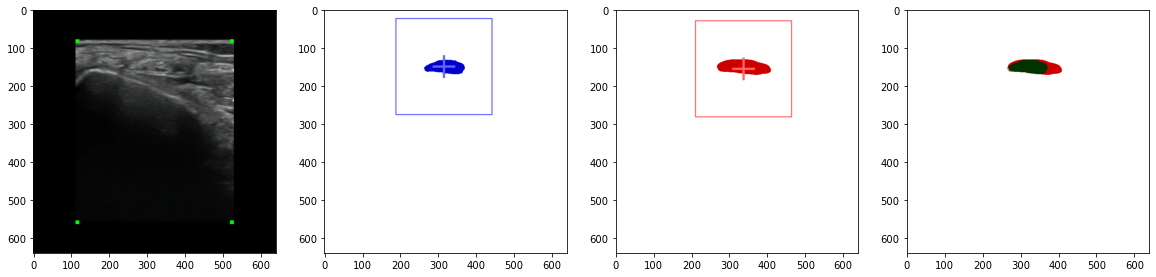

torch.Size([3, 640, 640]) torch.Size([640, 640])
[208 339] [156 336]


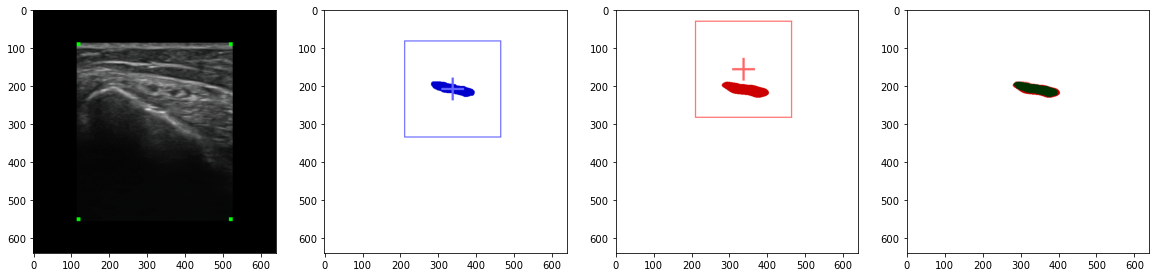

torch.Size([3, 640, 640]) torch.Size([640, 640])
[242 327] [156 336]


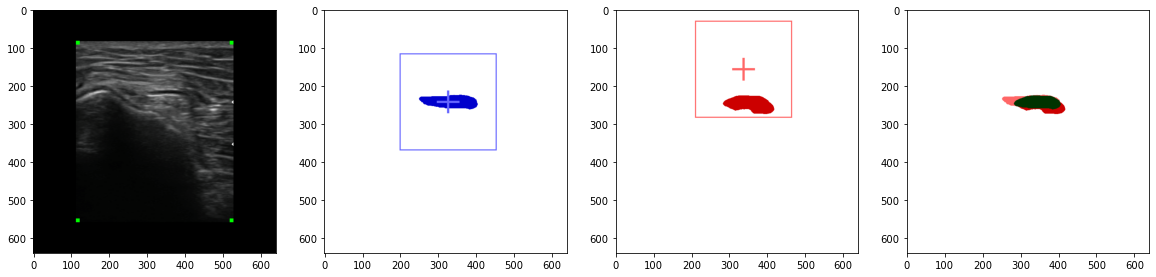

 67%|██████▋   | 4/6 [00:16<00:07,  3.99s/it]

lt: [29, 207], rb: [285, 463]
anchor[0]: tensor([157, 335], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[116 349] [157 335]


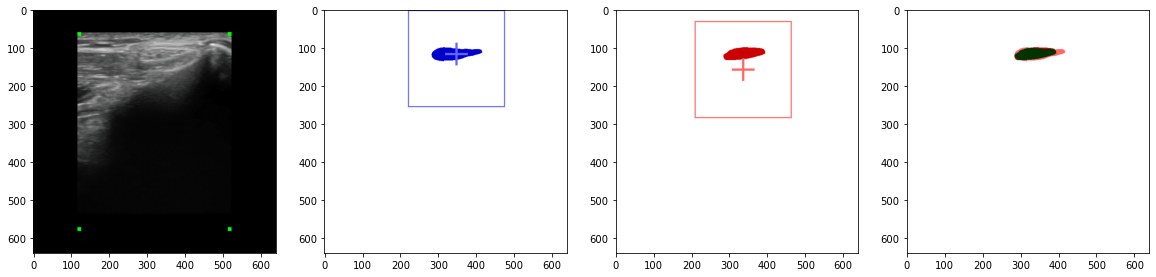

torch.Size([3, 640, 640]) torch.Size([640, 640])
[194 346] [156 336]


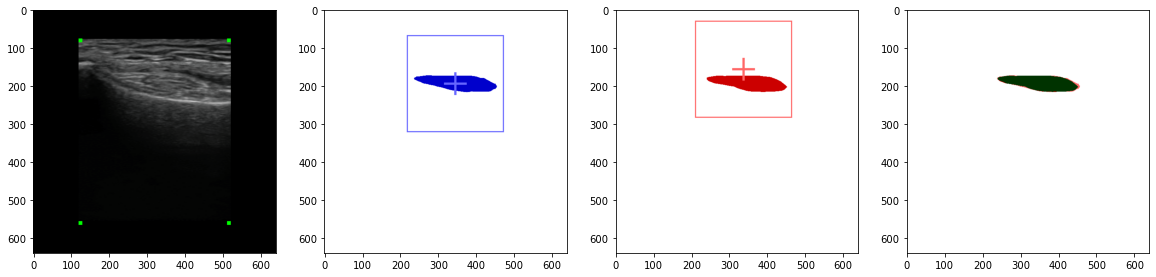

torch.Size([3, 640, 640]) torch.Size([640, 640])
[195 343] [155 336]


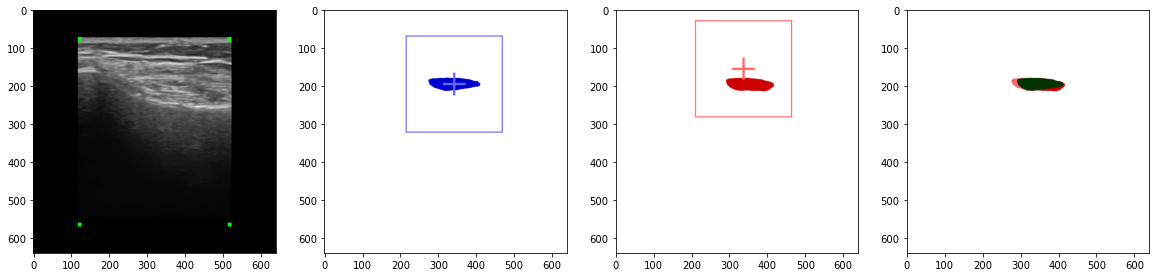

torch.Size([3, 640, 640]) torch.Size([640, 640])
[152 374] [156 336]


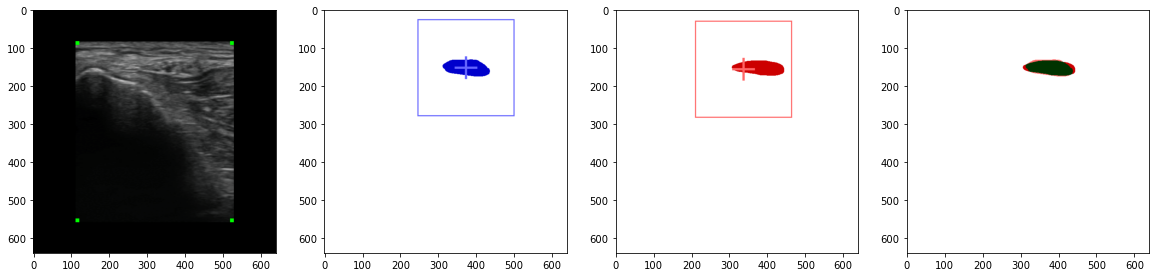

torch.Size([3, 640, 640]) torch.Size([640, 640])
[168 312] [156 337]


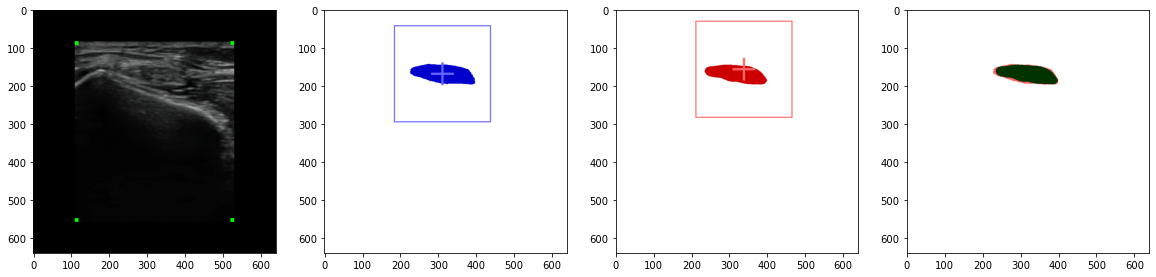

torch.Size([3, 640, 640]) torch.Size([640, 640])
[178 281] [156 336]


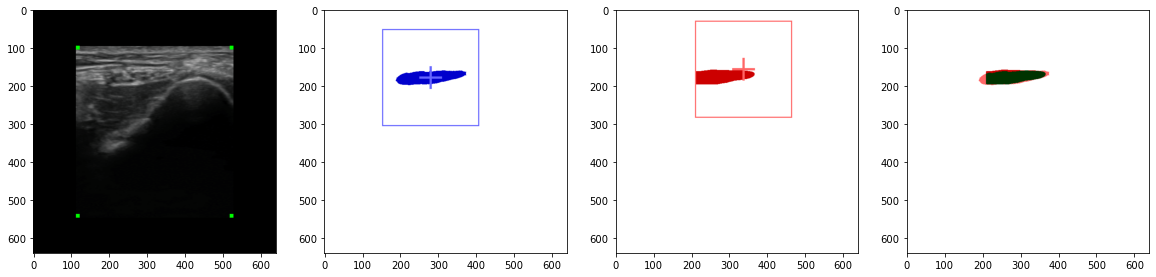

 83%|████████▎ | 5/6 [00:19<00:03,  3.87s/it]

lt: [29, 209], rb: [285, 465]
anchor[0]: tensor([157, 337], device='cuda:4', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[233 373] [157 337]


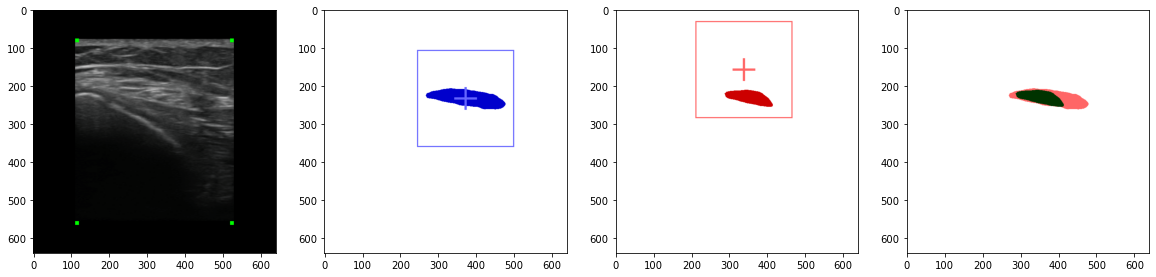

torch.Size([3, 640, 640]) torch.Size([640, 640])
[150 235] [156 336]


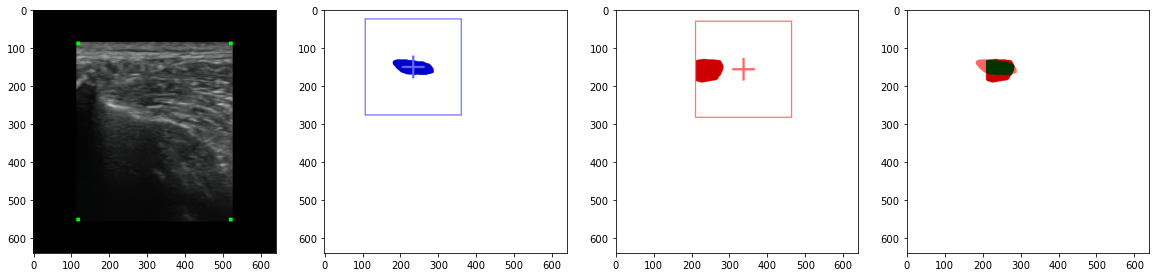

torch.Size([3, 640, 640]) torch.Size([640, 640])
[197 259] [156 337]


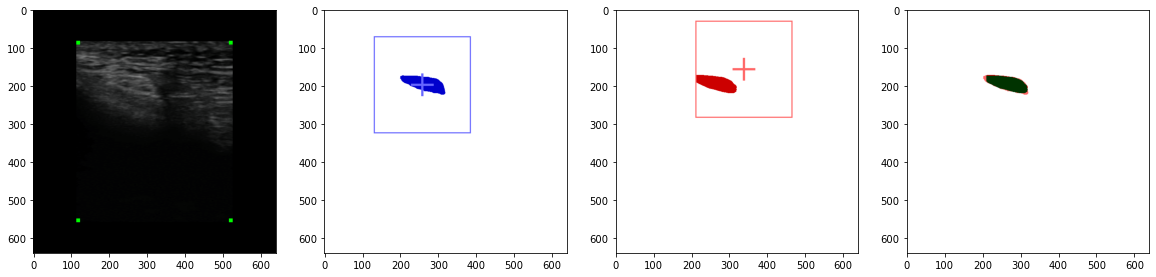

torch.Size([3, 640, 640]) torch.Size([640, 640])
[140 339] [156 336]


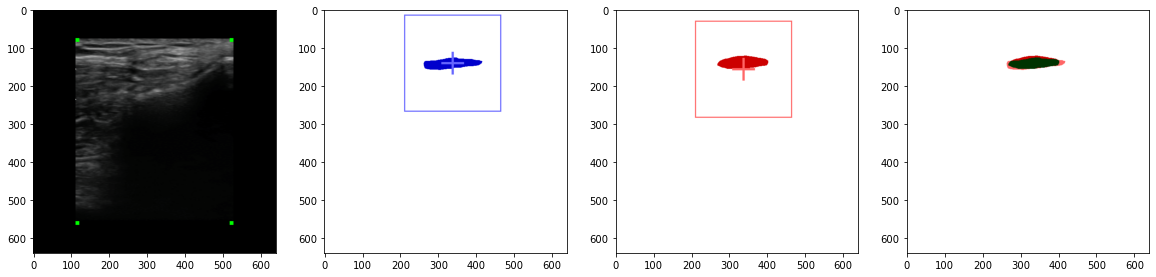

torch.Size([3, 640, 640]) torch.Size([640, 640])
[137 384] [156 336]


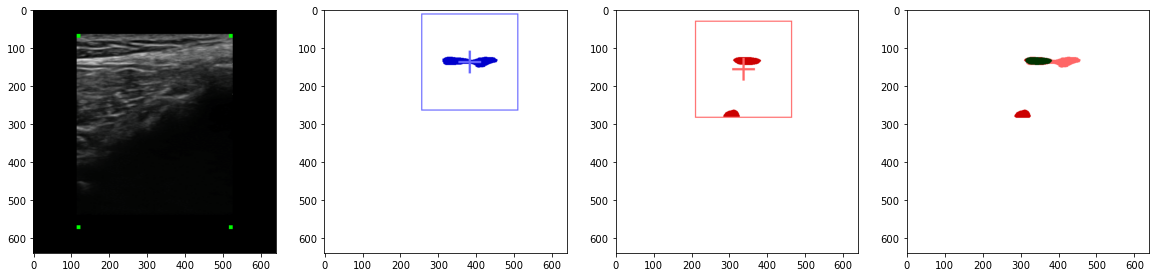

torch.Size([3, 640, 640]) torch.Size([640, 640])
[137 245] [156 336]


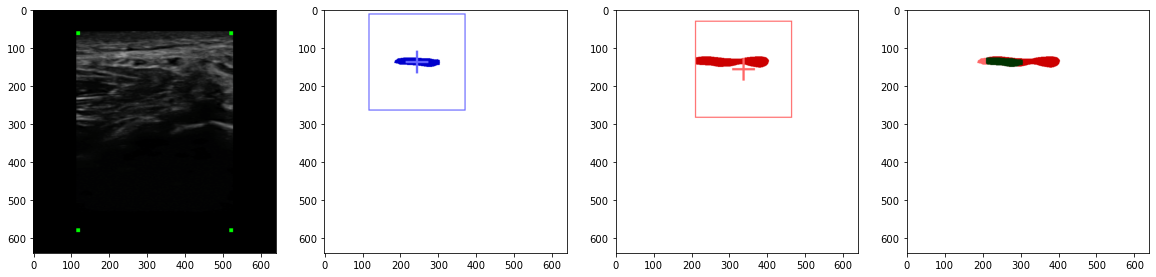

100%|██████████| 6/6 [00:23<00:00,  3.98s/it]

Epoch loss : 0.124295, 0.004618
Score : {'Overall Acc': 0.99506591796875, 'Mean Acc': 0.851083732341041, 'FreqW Acc': 0.9907750589109285, 'Mean IoU': 0.8047170392097776, 'Class IoU': {0: 0.995026818744261, 1: 0.6144072596752941}, 'Class F1': {0: 0.997507210825933, 1: 0.7611552239908409}}


In [41]:
running_loss = [0.0, 0.0]
mse = criterion.get_criterion.__dict__['mseloss']()
dice = criterion.get_criterion.__dict__['dice']()
metrics = utils.StreamSegMetrics(n_classes=2)
metrics.reset()

with torch.no_grad():
    for i, (ims, lbls) in tqdm(enumerate(loader), total=len(loader)):

        ims = ims.to(devices)
        mas = lbls[0].to(devices)
        bbox = lbls[1].to(devices)

        anchor = backbone(ims)
        mse_loss = mse(anchor, bbox)

        cims, cmas = crop(ims, mas, anchor, devices, crop_size=256)
        if i == 0:
            print('crop images, masks size: ', cims.size(), cmas.size())
        
        outputs = net(cims)
        probs = nn.Softmax(dim=1)(outputs)
        preds = recover(mas, torch.max(probs, 1)[1], anchor, devices, )

        dice_loss = dice(outputs, cmas)
        metrics.update(mas.detach().cpu().numpy(), preds.detach().cpu().numpy())

        running_loss[1] += (mse_loss.item() * ims.size(0))
        running_loss[0] += (dice_loss.item() * ims.size(0))

        #show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu())
        show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu(), preds.detach().cpu())
        #
        #_show(cims.detach().cpu(), cmas.detach().cpu())

        #_show(ims.detach().cpu(), result.detach().cpu())
        #print(f'{running_loss:.6f}, {mse_loss.item()}, {ims.size(0)}')
    #print(f'running loss : {running_loss:.6f} / {len(loader)}')
    epoch_loss = [running_loss[0] / len(loader.dataset), running_loss[1] / len(loader.dataset)]

print(f"Epoch loss : {epoch_loss[0]:.6f}, {epoch_loss[1]:.6f}")
print(f"Score : {metrics.get_results()}")